In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas e da Base de Dados

In [2]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

from sklearn.metrics import mean_squared_error

#tf.__version__

## Parte 1 - Importação do Dataset e Estatística Descritiva

In [3]:
# Importação da Base de Dados
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_C-4450_8601A.csv')
#dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_C-4451_08001A.csv')

# Eliminando as TAGs que não se referem aos mancais do equipamento
#dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCD.F_CV']
#dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCT.F_CV']

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EQUIPAMENTO  2314 non-null   object 
 1   MANCAL       2314 non-null   object 
 2   DATA         2314 non-null   object 
 3   TEMPERATURA  2314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 72.4+ KB


In [5]:
dataset.head()

,EQUIPAMENTO,MANCAL,DATA,TEMPERATURA
0,C-4450.8601A,ECI1.A-TC21.F_CV,04/01/2021,82.00747
1,C-4450.8601A,ECI1.A-TC21.F_CV,05/01/2021,84.24638
2,C-4450.8601A,ECI1.A-TC21.F_CV,06/01/2021,84.26843
3,C-4450.8601A,ECI1.A-TC21.F_CV,08/01/2021,37.84982
4,C-4450.8601A,ECI1.A-TC21.F_CV,31/01/2021,76.31767


In [6]:
#Conversão do campo data para datetime e ordenação do dataset
dataset['DATA'] = pd.to_datetime(dataset['DATA'],dayfirst=True)
dataset = dataset.sort_values(['EQUIPAMENTO', 'MANCAL', 'DATA'], ascending=[1, 1, 1])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314 entries, 0 to 2313
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   EQUIPAMENTO  2314 non-null   object        
 1   MANCAL       2314 non-null   object        
 2   DATA         2314 non-null   datetime64[ns]
 3   TEMPERATURA  2314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 90.4+ KB


In [7]:
dataset.groupby(['EQUIPAMENTO','MANCAL']).count()

DATA  TEMPERATURA
EQUIPAMENTO  MANCAL                                
C-4450.8601A ECI1.A-TC21.F_CV      136          136
             ECI1.A-TC22.F_CV      136          136
             ECI1.A-TC23.F_CV      136          136
             ECI1.A-TC25.F_CV      136          136
             ECI1.A-TC250.F_CV     136          136
             ECI1.A-TC251.F_CV     136          136
             ECI1.A-TC26.F_CV      136          136
             ECI1.A-TC27.F_CV      136          136
             ECI1.A-TC28.F_CV      136          136
             ECI1.A-TE1200A.F_CV   137          137
             ECI1.A-TE1200B.F_CV   136          136
             ECI1.A-TE1203A.F_CV   136          136
             ECI1.A-TE1203B.F_CV   136          136
             ECI1.A-TE1206A.F_CV   136          136
             ECI1.A-TE1206B.F_CV   136          136
             ECI1.A-TE1209A.F_CV   136          136
             ECI1.A-TE1209B.F_CV   137          137

In [8]:
#Separação do dataset por mancais
mancais = dataset['MANCAL'].unique().tolist()

manc1 = dataset[dataset['MANCAL'] == mancais[0]]
manc2 = dataset[dataset['MANCAL'] == mancais[1]]
manc3 = dataset[dataset['MANCAL'] == mancais[2]]
manc4 = dataset[dataset['MANCAL'] == mancais[3]]
manc5 = dataset[dataset['MANCAL'] == mancais[4]]
manc6 = dataset[dataset['MANCAL'] == mancais[5]]
manc7 = dataset[dataset['MANCAL'] == mancais[6]]

#Criação do dataframe com as datas registradas para pelo menos um dos mancais
lista_datas = dataset['DATA'].unique().tolist()
datas_registradas = pd.DataFrame(lista_datas,columns=['DATA'])
datas_registradas['DATA'] = pd.to_datetime(datas_registradas['DATA'],dayfirst=True)


In [9]:
# Ajuste dos datasets para incluir datas faltantes do conjunto e preencher os 
# dados faltantes. A temperatura será preenchida com a moda do conjunto de 
# temperaturas do mancal.
def completeDates( dates, dataset ):
  result = pd.merge(dates, dataset, on='DATA', how='outer')
  result['EQUIPAMENTO'].fillna(np.array(dataset['EQUIPAMENTO'])[0], inplace = True);
  result['MANCAL'].fillna(np.array(dataset['MANCAL'])[0], inplace = True);
  result['TEMPERATURA'].fillna(np.array(manc3['TEMPERATURA'].mode())[0], inplace = True)
  return result

#manc1 = completeDates( datas_registradas, manc1)
#manc1 = completeDates( datas_registradas, manc2)
#manc3 = completeDates( datas_registradas, manc3)
#manc4 = completeDates( datas_registradas, manc4)
#manc5 = completeDates( datas_registradas, manc5)
#manc6 = completeDates( datas_registradas, manc6)
#manc7 = completeDates( datas_registradas, manc7)

In [10]:
dataset.describe()

,TEMPERATURA
count,2314.000000
mean,68.859420
std,12.922652
min,31.440260
25%,57.464818
50%,67.678310
75%,78.997075
max,95.215090


#### Análise Gráfica

No handles with labels found to put in legend.


Text(0.5, 0, 'Temperatura')

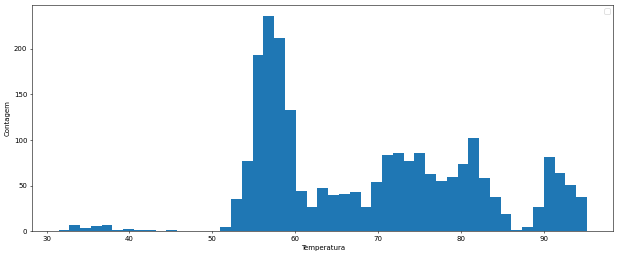

In [11]:
temperaturas = dataset.to_numpy()
temperaturas = temperaturas[:,3:4]
bins = np.linspace(temperaturas.min(), temperaturas.max(), 50)
plt.figure(figsize=(15, 6), dpi=50)
plt.hist(temperaturas, bins=bins)
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

Text(0.5, 0, 'Temperatura')

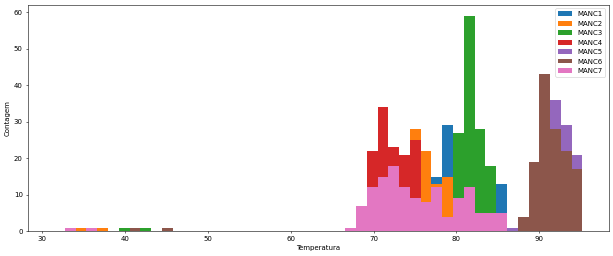

In [12]:
tempsManc1 = manc1.to_numpy()[:,3:4]
tempsManc2 = manc2.to_numpy()[:,3:4]
tempsManc3 = manc3.to_numpy()[:,3:4]
tempsManc4 = manc4.to_numpy()[:,3:4]
tempsManc5 = manc5.to_numpy()[:,3:4]
tempsManc6 = manc6.to_numpy()[:,3:4]
tempsManc7 = manc7.to_numpy()[:,3:4]

plt.figure(figsize=(15, 6), dpi=50)
plt.hist(tempsManc1, bins=bins, label='MANC1')
plt.hist(tempsManc2, bins=bins, label='MANC2')
plt.hist(tempsManc3, bins=bins, label='MANC3')
plt.hist(tempsManc4, bins=bins, label='MANC4')
plt.hist(tempsManc5, bins=bins, label='MANC5')
plt.hist(tempsManc6, bins=bins, label='MANC6')
plt.hist(tempsManc7, bins=bins, label='MANC7')
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

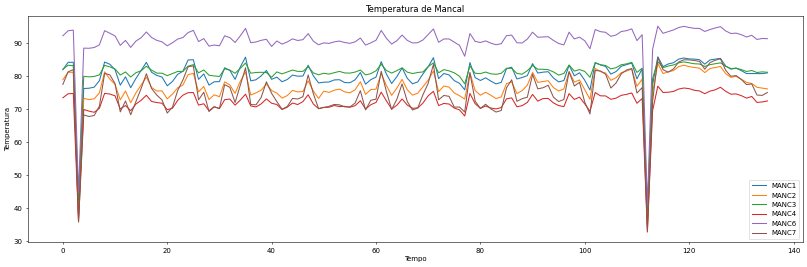

In [13]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(tempsManc1, label='MANC1')
plt.plot(tempsManc2, label='MANC2')
plt.plot(tempsManc3, label='MANC3')
plt.plot(tempsManc4, label='MANC4')
#plt.plot(tempsManc5, label='MANC5')
plt.plot(tempsManc6, label='MANC6')
plt.plot(tempsManc7, label='MANC7')

plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.legend()
plt.show()

## Parte 2 - Preprocessamento de Dados

### Separação do conjunto de Treino e Teste

In [14]:
window     = 6
output_size = 3

In [15]:
datasetMancal = manc7
#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
#datasetMancal = datasetMancal.astype({"TEMPERATURA": int})
datasetMancal['TEMPERATURA'] = datasetMancal['TEMPERATURA'].round(decimals=1)

#Calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(datasetMancal)*0.7)
test_size  = len(datasetMancal) - train_size

#Separando conjuto de treino e teste apenas com valor da série
train_set = datasetMancal.iloc[0:train_size, 3:4].values
test_set  = datasetMancal.iloc[train_size:(train_size + test_size), 3:4].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### gráfico da série temporal

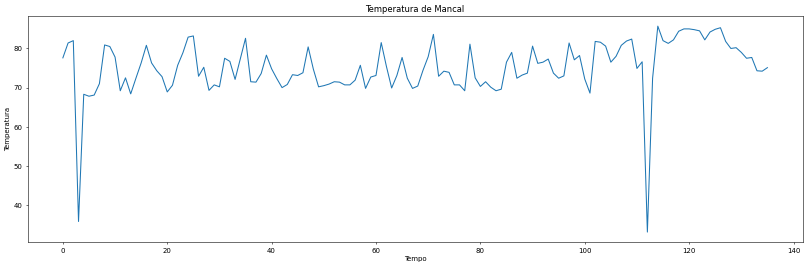

In [16]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(datasetMancal.iloc[0:len(datasetMancal), 3:4].values)
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

### Normalização

In [17]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [18]:
def prepareSetRN(windowSize, outputSize, flatSet ):
    preparedX = []
    preparedY = []
    setSize = len(flatSet)
    for i in range(windowSize, setSize - (outputSize-1)):
        preparedX.append(flatSet[i-window:i, 0])
        preparedY.append(flatSet[i:i + output_size, 0])

    preparedX, preparedY = np.array(preparedX), np.array(preparedY)
    return preparedX, preparedY

X_train = []
y_train = []
X_train, y_train = prepareSetRN(window, output_size, training_set_scaled)

### Reshaping

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Parte 3 - Construção da RNN

### Bibliotecas necessárias

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Construção da Rede completa

In [22]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.25))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = False))
regressor.add(Dropout(0.25))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 80, return_sequences = False))
#regressor.add(Dropout(0.25))

# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.25))

# camada de saída
regressor.add(Dense(units = output_size, activation='linear'))
#Testar sigmoid e linear

# Compilar a rede
regressor.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 6, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                73920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 243       
Total params: 165,363
Trainable params: 165,363
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [23]:
history = regressor.fit(X_train, y_train, epochs = 1200, batch_size = 20)

Epoch 1/1200
5/5 [==============================] - 3s 18ms/step - loss: 0.5311 - accuracy: 0.2500
Epoch 2/1200
5/5 [==============================] - 0s 15ms/step - loss: 0.1811 - accuracy: 0.2955
Epoch 3/1200
5/5 [==============================] - 0s 18ms/step - loss: 0.0674 - accuracy: 0.3068
Epoch 4/1200
5/5 [==============================] - 0s 18ms/step - loss: 0.0411 - accuracy: 0.3182
Epoch 5/1200
5/5 [==============================] - 0s 21ms/step - loss: 0.0426 - accuracy: 0.4318
Epoch 6/1200
5/5 [==============================] - 0s 20ms/step - loss: 0.0294 - accuracy: 0.3295
Epoch 7/1200
5/5 [==============================] - 0s 16ms/step - loss: 0.0213 - accuracy: 0.3182
Epoch 8/1200
5/5 [==============================] - 0s 15ms/step - loss: 0.0188 - accuracy: 0.3409
Epoch 9/1200
5/5 [==============================] - 0s 15ms/step - loss: 0.0219 - accuracy: 0.3636
Epoch 10/1200
5/5 [==============================] - 0s 19ms/step - loss: 0.0192 - accuracy: 0.3750
Epoch 11/

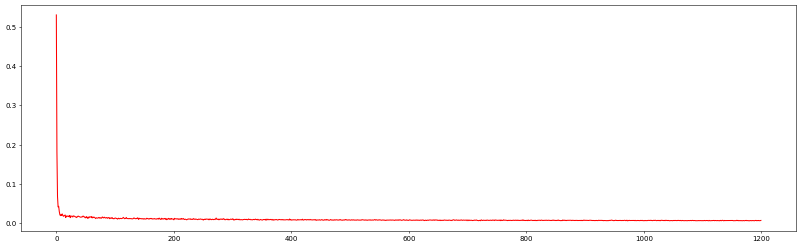

In [24]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['loss'], color = 'red', label = 'Loss')

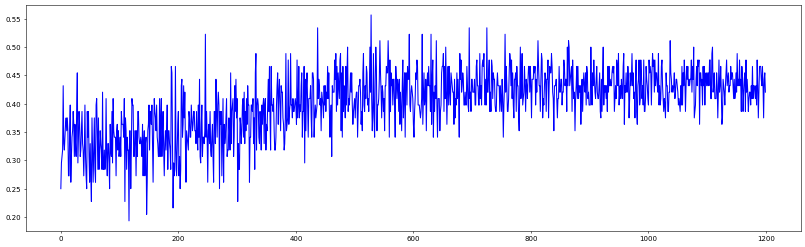

In [25]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['accuracy'], color = 'blue', label = 'Accuracy')

## Parte 4 - Fazer as previsões e analisar os resultados

### Base de teste

### Construir a estrutura para teste

In [26]:
#Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
test_set_first_window  = dataset.iloc[train_size - window:(train_size + test_size), 3:4].values

test_set_scaled = sc.transform(test_set_first_window)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output_size, test_set_scaled)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [27]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    #Adiciona as primeiras colunas do primeiro registro quando a janela > 1
    if window_size > 1:
      for i in range(0, window_size-1):
        flatSet.append(windowSet[0, i])

    for i in range(0, setSize):
        flatSet.append(windowSet[i, window_size-1])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

predicted = regressor.predict(X_train)
predicted = sc.inverse_transform(predicted)

training_predicted = backToFlat(predicted)

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

### Visualizar os resultados de treino e teste

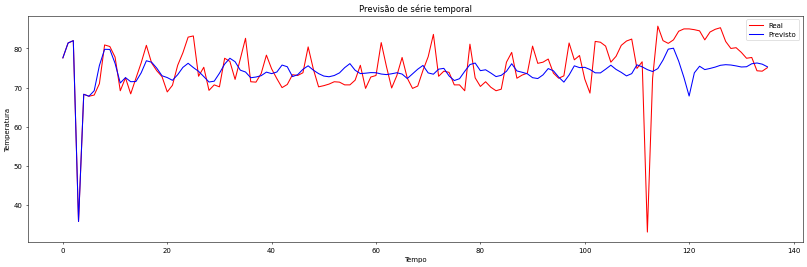

In [28]:
#allTargetData = np.vstack((test_set))
#allForecastedData = np.vstack((test_predicted))
allTargetData = np.vstack((train_set, test_set))
allForecastedData = np.vstack((train_set[0:window], training_predicted, test_predicted))

plt.figure(figsize=(20, 6), dpi=50)
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

In [29]:
for i in range(0, 20):
  print( allTargetData[i], allForecastedData[i])

[77.6] [77.6]
[81.4] [81.4]
[82.] [82.]
[35.8] [35.8]
[68.3] [68.3]
[67.8] [67.8]
[68.1] [69.19915009]
[71.] [75.65116882]
[80.9] [79.78495789]
[80.5] [79.75369263]
[77.8] [76.2085495]
[69.2] [71.18486786]
[72.5] [72.55867767]
[68.4] [71.50886536]
[72.4] [71.56152344]
[76.3] [73.76451874]
[80.8] [76.85662079]
[76.3] [76.49739075]
[74.3] [74.95951843]
[72.8] [73.02693176]


## Parte 5 - Métricas de avaliação

In [30]:
rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
print('RMSE: ', rmse)

RMSE:  9.38346918255824


In [31]:
mse = mean_squared_error(test_set, test_predicted)
print('MSE: ',mse)

MSE:  88.04949390002022


In [32]:
mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100
print('MAPE: ',mape, '%')

MAPE:  9.768586639776673 %
